In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchmcr.synthetic.randomgaussians import generate_spectra
from torchmcr.basemodel import MCR
from torchmcr.simplemcr import NormalizedSpectraMCRModel, SimpleMCRModel
from torchmcr.train import train_mcr_model
from torchmcr.loss_models.smooth_loss import create_smooth_loss
from torchmcr.loss_models.loss_registry import MCRLossRegistry
from torchmcr.spectrainit import simplisma
from torchmcr.utils.domain_constraints import inverse_normalized_softmax, normalized_softmax, inverse_softplus


import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

In [2]:
waves, data = generate_spectra(3, 10, amplitude_limits=[1,2], variance_limits=[20,40])
print(data.shape)
norma = np.sum(data, axis=-1)
data = 1000*data/norma[:,None]
print(data.shape)
times = np.linspace(0,1,1000)
weights = np.vstack( [np.exp(-(times-0.1)**2/(2.0*0.05**2)),
                      np.exp(-(times-0.5)**2/(2.0*0.07**2)),
                      np.exp(-(times-0.85)**2/(2.0*0.05**2)),
                     ]
                   ).T


(3, 1000)
(3, 1000)


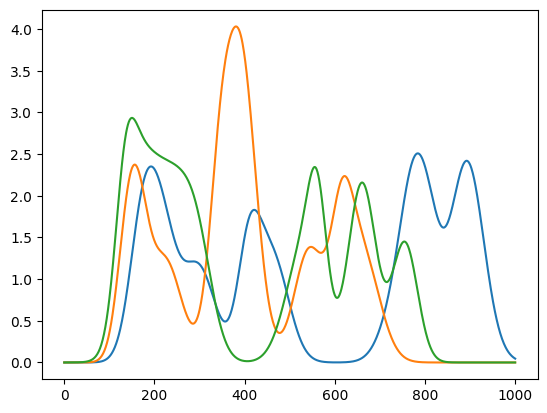

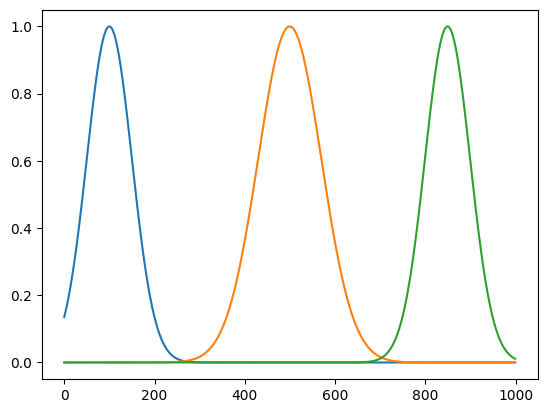

In [3]:
for s in data:
    plt.plot(waves, s)
plt.show()
for tmp in weights.T:
    plt.plot(tmp)
plt.show()

In [4]:
data = torch.Tensor(data)
weights = torch.Tensor(weights)

torch.Size([1000, 1000])


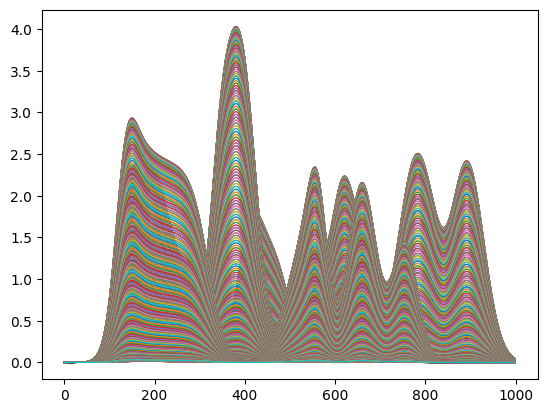

In [5]:
reference_mcr = SimpleMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            preload_weights=weights,
                            preload_spectra=data
                           )
reference_mcr.freeze_spectra()
reference_mcr.freeze_weights()
# Forward pass without additional arguments
observed_data = reference_mcr().detach()
print(observed_data.shape)

for s in observed_data:
    plt.plot(s.detach().numpy(), lw=0.8)
plt.show()



In [6]:
trial1_mcr = NormalizedSpectraMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            preload_weights=weights,
                            preload_spectra=None, 
                           )

trial1_mcr.freeze_weights()

In [7]:
# First create the loss registry with desired weights
loss_registry = create_smooth_loss(
    base_loss_fn=F.l1_loss,
    smooth_spectra_weight=0.0,
    smooth_weight_weight=0.0,
    weight_cross_product_weight=0.0
)

# Then use it in training with a lambda function
train_mcr_model(
    trial1_mcr, 
    observed_data, 
    num_epochs=1000, 
    mini_epochs=5, 
    lr=0.001, 
    tolerance=1e-12,
    optimizer_class=torch.optim.Adam, 
    loss_fn=lambda predicted, target: loss_registry.compute_total_loss(
        trial1_mcr,
        predicted=predicted,
        target=target,
        spectra_kwargs={},
        weights_kwargs={}
    )[0],  # Note the [0] to get just the total loss value
    device="cpu"
)

Epoch 1/1000, Loss: 0.071459
Epoch 11/1000, Loss: 0.067397
Epoch 21/1000, Loss: 0.063397
Epoch 31/1000, Loss: 0.059501
Epoch 41/1000, Loss: 0.055739
Epoch 51/1000, Loss: 0.052123
Epoch 61/1000, Loss: 0.048672
Epoch 71/1000, Loss: 0.045384
Epoch 81/1000, Loss: 0.042285
Epoch 91/1000, Loss: 0.039373
Epoch 101/1000, Loss: 0.036671
Epoch 111/1000, Loss: 0.034158
Epoch 121/1000, Loss: 0.031831
Epoch 131/1000, Loss: 0.029679
Epoch 141/1000, Loss: 0.027689
Epoch 151/1000, Loss: 0.025860
Epoch 161/1000, Loss: 0.024177
Epoch 171/1000, Loss: 0.022631
Epoch 181/1000, Loss: 0.021207
Epoch 191/1000, Loss: 0.019893
Epoch 201/1000, Loss: 0.018687
Epoch 211/1000, Loss: 0.017583
Epoch 221/1000, Loss: 0.016561
Epoch 231/1000, Loss: 0.015622
Epoch 241/1000, Loss: 0.014759
Epoch 251/1000, Loss: 0.013961
Epoch 261/1000, Loss: 0.013223
Epoch 271/1000, Loss: 0.012536
Epoch 281/1000, Loss: 0.011893
Epoch 291/1000, Loss: 0.011292
Epoch 301/1000, Loss: 0.010730
Epoch 311/1000, Loss: 0.010205
Epoch 321/1000, Los

In [8]:
recovered_spectra = trial1_mcr.spectra().clone()

In [9]:
recovered_weights = trial1_mcr.weights().clone()

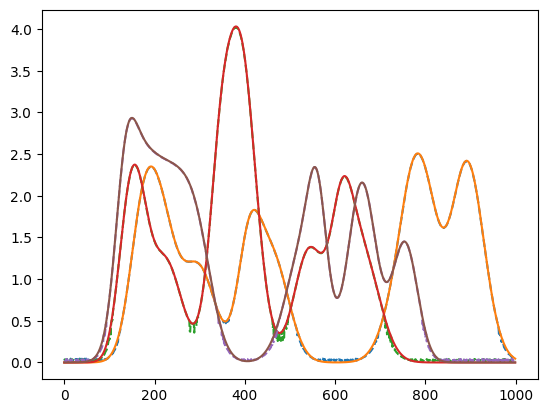

In [11]:
for s, ss in zip(recovered_spectra, data):
    plt.plot(s.detach().cpu().numpy(), '--')
    plt.plot(ss.cpu().numpy(), )

In [12]:


import torch
import torch.nn.functional as F

loss_registry = create_smooth_loss(
    base_loss_fn=F.l1_loss,
    smooth_spectra_weight=1.0,
    smooth_weight_weight=1.0,
    weight_cross_product_weight=0.01
)


trial2_mcr = NormalizedSpectraMCRModel(M_samples=weights.shape[0], 
                            K_components=weights.shape[1], 
                            N_waves=data.shape[-1],
                            preload_weights=None,
                            preload_spectra=data,
                            weights_modifier=torch.nn.Softplus()
                           )
trial2_mcr.freeze_spectra()


# Then use it in training with a lambda function
train_mcr_model(
    trial2_mcr, 
    observed_data, 
    num_epochs=1000, 
    mini_epochs=5, 
    lr=0.05, 
    tolerance=1e-12,
    optimizer_class=torch.optim.Adam, 
    loss_fn=lambda predicted, target: loss_registry.compute_total_loss(
        trial2_mcr,
        predicted=predicted,
        target=target,
        spectra_kwargs={},
        weights_kwargs={}
    )[0],  # Note the [0] to get just the total loss value
    device="cpu"
)

Epoch 1/1000, Loss: 0.449887
Epoch 11/1000, Loss: 0.077843
Epoch 21/1000, Loss: 0.032986
Epoch 31/1000, Loss: 0.020181
Epoch 41/1000, Loss: 0.014712
Epoch 51/1000, Loss: 0.011837
Epoch 61/1000, Loss: 0.010134
Epoch 71/1000, Loss: 0.009035
Epoch 81/1000, Loss: 0.008277
Epoch 91/1000, Loss: 0.007729
Epoch 101/1000, Loss: 0.007314
Epoch 111/1000, Loss: 0.006992
Epoch 121/1000, Loss: 0.006736
Epoch 131/1000, Loss: 0.006533
Epoch 141/1000, Loss: 0.006361
Epoch 151/1000, Loss: 0.006220
Epoch 161/1000, Loss: 0.006101
Epoch 171/1000, Loss: 0.006000
Epoch 181/1000, Loss: 0.005912
Epoch 191/1000, Loss: 0.005838
Epoch 201/1000, Loss: 0.005771
Epoch 211/1000, Loss: 0.005713
Epoch 221/1000, Loss: 0.005662
Epoch 231/1000, Loss: 0.005617
Epoch 241/1000, Loss: 0.005576
Epoch 251/1000, Loss: 0.005539
Epoch 261/1000, Loss: 0.005506
Epoch 271/1000, Loss: 0.005477
Epoch 281/1000, Loss: 0.005449
Epoch 291/1000, Loss: 0.005427
Epoch 301/1000, Loss: 0.005402
Epoch 311/1000, Loss: 0.005384
Epoch 321/1000, Los

In [13]:
recovered_weights = trial2_mcr.weights().clone()

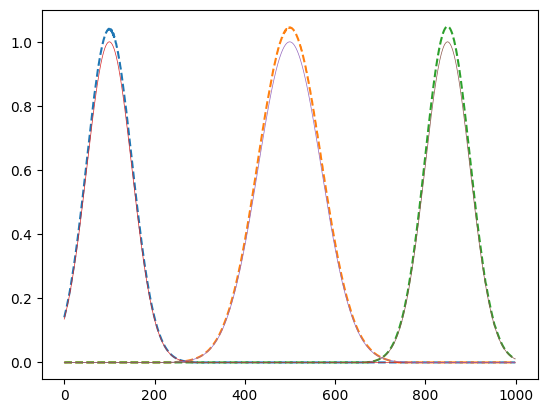

In [14]:
t = np.arange(100)
plt.plot(recovered_weights[:,0].detach().cpu().numpy(), "--", )
plt.plot(recovered_weights[:,1].detach().cpu().numpy(), "--")
plt.plot(recovered_weights[:,2].detach().cpu().numpy(), "--")
plt.plot(weights[:,0].detach().cpu().numpy(), lw=.5)
plt.plot(weights[:,1].detach().cpu().numpy(), lw=.5)
plt.plot(weights[:,2].detach().cpu().numpy(), lw=.5)


In [15]:
from torchmcr.spectrainit import simplisma

In [16]:
start_spectra = simplisma(observed_data, 3)

In [23]:
plt.plot(start_spectra[0]/torch.sum(start_spectra[0]) )
plt.plot(start_spectra[1]/torch.sum(start_spectra[1]))
plt.plot(start_spectra[2]/torch.sum(start_spectra[2]))
plt.plot(data[0]/np.sum(data[0]), "--")
plt.plot(data[1]/np.sum(data[0]), "--")
plt.plot(data[2]/np.sum(data[0]), "--")

plt.show()

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [17]:
trial3_mcr = NormalizedSpectraMCRModel(M_samples=weights.shape[0], 
                            K_components=3, 
                            N_waves=data.shape[-1],
                            preload_weights=None,
                            preload_spectra=start_spectra,
                            weights_modifier=torch.nn.Softplus())


In [ ]:
loss_registry = create_smooth_loss(
    base_loss_fn=F.l1_loss,
    smooth_spectra_weight=0.0,
    smooth_weight_weight=0.0,
    weight_cross_product_weight=10.0
)

trial3_mcr.unfreeze_spectra()

train_mcr_model(trial3_mcr, 
                observed_data, 
                num_epochs=500, 
                mini_epochs=30, 
                lr=0.01, 
                tolerance=1e-6, 
                optimizer_class=torch.optim.Adam, 
                loss_fn=lambda predicted, target: loss_registry.compute_total_loss(
                    trial3_mcr,
                    predicted=predicted,
                    target=target,
                    spectra_kwargs={},
                    weights_kwargs={})[0],  # Note the [0] to get just the total loss value
                device="cpu")

train_mcr_model(trial3_mcr, 
                observed_data, 
                num_epochs=500, 
                mini_epochs=30, 
                lr=0.001, 
                tolerance=1e-8, 
                optimizer_class=torch.optim.Adam, 
                loss_fn=lambda predicted, target: loss_registry.compute_total_loss(
                    trial3_mcr,
                    predicted=predicted,
                    target=target,
                    spectra_kwargs={},
                    weights_kwargs={})[0],  # Note the [0] to get just the total loss value
                device="cpu")



In [22]:
with torch.no_grad():
    www = trial3_mcr.weights.forward().clone().cpu().numpy()
    sss = trial3_mcr.spectra.forward().clone().cpu().numpy()
    
    

In [ ]:
plt.plot(sss[0,...])
plt.plot(sss[1,...])
plt.plot(sss[2,...])
plt.show()
for s in data:
    plt.plot(waves, s, '--')
plt.show()

plt.plot(www[:,0])
plt.plot(www[:,1])
plt.plot(www[:,2])
plt.legend(range(3))

plt.show()
